In [ ]:
!pip install -r requirements.txt

In [47]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

In [48]:
#Caricamento dataset
train_path = './train.csv'
test_path = './test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## Preprocessing

In [49]:
#Assign int values for y column
train['No-show'] = train['No-show'].map({'Yes':1, 'No':0})
test['No-show'] = test['No-show'].map({'Yes':1, 'No':0})

In [50]:
train['No-show'].nunique()

2

In [51]:
# Column data replace/Removing null values/ missing data -> NON TROVATI
#for i in ['listOfStuff']: 
#    train[i]  = train[i].replace({'' : '' or np.NaN})
#    test[i] = test[i].replace({'':'' or np.NaN})

In [52]:
#Drop nulli -> NON TROVATI
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)

In [53]:
#Remove unusual data 
train['Age'] = train['Age'].mask(train['Age']<0, np.NaN)
test['Age'] = test['Age'].mask(train['Age']<0, np.NaN)
train['Age'] = train['Age'].mask(train['Age']>100, np.NaN)
test['Age'] = test['Age'].mask(train['Age']>100, np.NaN)

train['Handcap'] = train['Handcap'].mask(train['Handcap']>0,1)
test['Handcap'] = test['Handcap'].mask(test['Handcap']>0,1)

train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [54]:
#Add a column difference of days between scheduled and appointment
#Add columns for scheduled day/month/year/hour/weekday and 
# appointment day day/month/year/weekday
train['ScheduledDay'] = pd.to_datetime(train['ScheduledDay'])
#removed because they don't change anything
#train['Scheduled_Day'] = train['ScheduledDay'].dt.day
#train['Scheduled_Month'] = train['ScheduledDay'].dt.month
#train['Scheduled_Year'] = train['ScheduledDay'].dt.year
#train['Scheduled_Hour'] = train['ScheduledDay'].dt.hour
#train['Scheduled_Day_Of_Week'] = train['ScheduledDay'].dt.dayofweek
train['ScheduledDay'] = train['ScheduledDay'].dt.date
train['AppointmentDay'] = pd.to_datetime(train['AppointmentDay'])
#removed because they don't change anything
#train['Appointment_Day'] = train['AppointmentDay'].dt.day
#train['Appointment_Month'] = train['AppointmentDay'].dt.month
#train['Appointment_Year'] = train['AppointmentDay'].dt.year one unique value
#train['Appointment_Day_Of_Week'] = train['AppointmentDay'].dt.dayofweek
train['AppointmentDay'] = train['AppointmentDay'].dt.date
train['Diff_Days_bw_Sch_App'] = ((train['AppointmentDay']-train['ScheduledDay']).dt.days)


test['ScheduledDay'] = pd.to_datetime(test['ScheduledDay'])
#removed because they don't change anything
#test['Scheduled_Day'] = test['ScheduledDay'].dt.day
#test['Scheduled_Month'] = test['ScheduledDay'].dt.month
#test['Scheduled_Year'] = test['ScheduledDay'].dt.year 
#test['Scheduled_Hour'] = test['ScheduledDay'].dt.hour
test['Scheduled_Day_Of_Week'] = test['ScheduledDay'].dt.dayofweek
test['ScheduledDay'] =test['ScheduledDay'].dt.date
test['AppointmentDay'] = pd.to_datetime(test['AppointmentDay'])
#removed because they don't change anything
#test['Appointment_Day'] = test['AppointmentDay'].dt.day
#test['Appointment_Month'] = test['AppointmentDay'].dt.month
#test['Appointment_Year'] = test['AppointmentDay'].dt.year one unique value
#test['Appointment_Day_Of_Week'] = test['AppointmentDay'].dt.dayofweek
test['AppointmentDay'] =test['AppointmentDay'].dt.date

test['Diff_Days_bw_Sch_App'] = ((test['AppointmentDay']-test['ScheduledDay']).dt.days)


train=train[train['Diff_Days_bw_Sch_App']>=0]
test=test[test['Diff_Days_bw_Sch_App']>=0]

train = train.drop(columns='ScheduledDay')
test = test.drop(columns='ScheduledDay')
#train = train.drop(columns='AppointmentDay')
#test = test.drop(columns='AppointmentDay')

#train['Scheduled_Day_Of_Week']

In [55]:
#Gender and Alcoholism are nearly equal in relation to No-Show
checklist = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']
for i in checklist:
    print(train.groupby(i)['No-show'].mean())

Gender
F    0.203054
M    0.198964
Name: No-show, dtype: float64
Scholarship
0    0.197564
1    0.238332
Name: No-show, dtype: float64
Hipertension
0    0.208566
1    0.173251
Name: No-show, dtype: float64
Diabetes
0    0.203707
1    0.174471
Name: No-show, dtype: float64
Alcoholism
0    0.201820
1    0.195077
Name: No-show, dtype: float64
SMS_received
0    0.165805
1    0.277131
Name: No-show, dtype: float64


In [56]:
#Identifying features
# 'Scheduled_Day', 'Scheduled_Month', 'Scheduled_Year','Scheduled_Hour','Scheduled_Day_Of_Week',
#'Appointment_Day', 'Appointment_Month','Appointment_Day_Of_Week',
features = [ 'Diff_Days_bw_Sch_App', 'AppointmentDay', 'Age','Neighbourhood', 'Scholarship', 'Hipertension',
            'Diabetes', 'Handcap', 'SMS_received']
non_numerical_features = ['Neighbourhood', 'AppointmentDay']

In [57]:
#Drop useless columns/ unique or with no correlation
train.index = train['AppointmentID']
test.index = test['AppointmentID']
train = train.drop(columns='AppointmentID')
test = test.drop(columns='AppointmentID')

In [58]:
#train['ScheduledDay'] = train['ScheduledDay'].astype(str)
#test['ScheduledDay'] = test['ScheduledDay'].astype(str)

#train['AppointmentDay'] = train['AppointmentDay'].astype(str)
#test['AppointmentDay'] = test['AppointmentDay'].astype(str)

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70729 entries, 5776992 to 5622732
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   No-show               70729 non-null  int64  
 1   PatientId             70729 non-null  float64
 2   Gender                70729 non-null  object 
 3   AppointmentDay        70729 non-null  object 
 4   Age                   70729 non-null  float64
 5   Neighbourhood         70729 non-null  object 
 6   Scholarship           70729 non-null  int64  
 7   Hipertension          70729 non-null  int64  
 8   Diabetes              70729 non-null  int64  
 9   Alcoholism            70729 non-null  int64  
 10  Handcap               70729 non-null  int64  
 11  SMS_received          70729 non-null  int64  
 12  Diff_Days_bw_Sch_App  70729 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 7.6+ MB


In [60]:
#y contains previously unseen labels

# Encoding strings of the data set into labels
#le = preprocessing.LabelEncoder()
#for column in non_numerical_features:
#    print(column)
#    #le.fit(pd.concat([train[column],test[column]], axis=0, ignore_index=True))
#    le.fit(train[column])
#    test[column] = test[column].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#    train[column] = le.fit_transform(train[column])
#    test[column] = le.transform(test[column])

label_train = train.copy()
label_test = test.copy()
le = preprocessing.LabelEncoder()
for column in non_numerical_features:
    label_train[column] = le.fit(train[column])
    label_test[column] = label_test[column].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    label_train[column] = le.transform(train[column])
    label_test[column] = le.transform(label_test[column])
    
train = label_train
test = label_test

In [61]:
train

,No-show,PatientId,Gender,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Diff_Days_bw_Sch_App
AppointmentID,,,,,,,,,,,,,
5776992,0,1.195732e+10,M,25,0.0,43,0,0,0,0,0,0,1
5755420,0,2.193125e+13,F,21,37.0,13,0,0,0,0,0,0,0
5722063,0,3.588818e+13,M,17,81.0,66,0,0,0,1,0,1,4
5592741,0,5.634754e+14,M,18,41.0,30,0,0,0,0,0,0,37
5691281,0,7.686731e+14,F,9,30.0,69,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733742,0,3.181769e+13,F,21,20.0,75,0,0,0,0,0,0,8
5590264,1,4.249772e+14,M,2,7.0,33,0,0,0,0,0,0,18
5672897,1,4.935222e+11,M,9,25.0,59,0,0,0,0,0,0,3


In [62]:
for i in features:
    print(train.groupby(i)['No-show'].mean())

Diff_Days_bw_Sch_App
0      0.045226
1      0.215152
2      0.232243
3      0.242183
4      0.227043
         ...   
155    0.625000
162    0.250000
169    0.000000
176    0.363636
179    0.142857
Name: No-show, Length: 126, dtype: float64
AppointmentDay
0     0.200867
1     0.196833
2     0.194918
3     0.242413
4     0.188889
5     0.212158
6     0.226938
7     0.223756
8     0.197105
9     0.185092
10    0.232291
11    0.190476
12    0.227553
13    0.213547
14    0.204635
15    0.205166
16    0.233691
17    0.203137
18    0.189717
19    0.200069
20    0.185265
21    0.165695
22    0.192239
23    0.194391
24    0.186604
25    0.179887
26    0.169268
Name: No-show, dtype: float64
Age
0.0      0.175814
1.0      0.175339
2.0      0.156371
3.0      0.178138
4.0      0.227545
           ...   
95.0     0.235294
96.0     0.000000
97.0     0.222222
98.0     0.200000
100.0    0.000000
Name: No-show, Length: 100, dtype: float64
Neighbourhood
0     0.125000
1     0.225716
2     0.149733
3     

In [63]:
#Separate features from y
train_X = train[features]
train_y = train['No-show']
val_X = test[features]
val_y = test['No-show']

In [64]:
# More processing
sc = StandardScaler()
train_X = pd.DataFrame(sc.fit_transform(train_X))
val_X = pd.DataFrame(sc.transform(val_X))

## Addestramento

In [65]:
#RESULT: 79-79, best (slightly)
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, max_depth=3, max_leaf_nodes=5)
model.fit(train_X,train_y)

predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print(predicted)
print(mae)
print(train_accuracy)
print(test_accuracy)

[0 0 0 ... 0 0 0]
0.20459172133001582
79.83853864751374
79.54082786699843


In [66]:
#RESULT: 79-79
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)
model.fit(train_X, train_y)

predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print('Mean absolute error: ')
print(mae)
print('Training set accuracy: ')
print(train_accuracy)
print('Test set accuracy: ')
print(test_accuracy)

Mean absolute error: 
0.20877629495589234
Training set accuracy: 
79.46245528708168
Test set accuracy: 
79.12237050441077


In [67]:
#RESULT
## TO CHECK WITH OTHER VARIABLES, LIKE NUMBER OF LEAVES
#from sklearn.tree import DecisionTreeClassifier
#best=[0,0,0,0,0]
#for j in range(2,50):
#    for i in range(1,10):
#        model = DecisionTreeClassifier(random_state=0, max_leaf_nodes = j, max_depth=i)
#        model.fit(train_X,train_y)
#        predicted = model.predict(val_X)
#        print(i)
#        mae = mean_absolute_error(val_y,predicted)
#        print(predicted)
#        train_accuracy = model.score(train_X,train_y)*100
#        test_accuracy = model.score(val_X,val_y)*100
#        print(mae)
#        print(train_accuracy)
#        print(test_accuracy)
#        if test_accuracy > best[2]:
#            best[0] = i
#            best[1] = train_accuracy
#            best[2] = test_accuracy
#            best[3] = mae
#            best[4] = j
#print(best)

In [68]:
#RESULT = overfit
#from sklearn.neighbors import KNeighborsClassifier

#model = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
#model.fit(train_X, train_y)

#predicted = model.predict(val_X)
#mae = mean_absolute_error(val_y,predicted)

#train_accuracy = model.score(train_X,train_y)*100
#test_accuracy = model.score(val_X,val_y)*100

#print(predicted)
#print(mae)
#print(train_accuracy)
#print(test_accuracy)

[1 0 0 ... 0 0 0]
0.23037774259217372
83.29115355794653
76.96222574078263


In [69]:
#RESULT
#from sklearn.neighbors import KNeighborsClassifier
#results=[]
#best=[0,0,0,0]
#for i in range(1,30):
#    model = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
#    model.fit(train_X, train_y)
#    predicted = model.predict(val_X)
#    print(i)
#    mae = mean_absolute_error(val_y,predicted)
#    print(predicted)
#    train_accuracy = model.score(train_X,train_y)*100
#    test_accuracy = model.score(val_X,val_y)*100
#    print(mae)
#    print(train_accuracy)
#    print(test_accuracy)
#    results.append(mae) 
#    if test_accuracy > best[2]:
#        best[0] = i
#        best[1] = train_accuracy
#        best[2] = test_accuracy
#        best[3] = mae
#from statistics import mean
#mean(results)
#print(best) 

## Conclusione

In [70]:
#Classifier scelto: DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, max_depth=3, max_leaf_nodes=5)
model.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, random_state=0)

In [71]:
predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print(predicted)
print(mae)
print(train_accuracy)
print(test_accuracy)

[0 0 0 ... 0 0 0]
0.20459172133001582
79.83853864751374
79.54082786699843


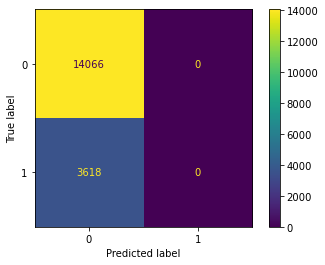

In [72]:
plot_confusion_matrix(model,val_X,val_y)